In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import itertools
from sklearn.metrics import mean_absolute_error

from time import time

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\pmdarima\__init__.py:107: UserWarning: pmdarima support for 32-bit systems is ending with Python 3.10.Your system is not guaranteed to work going forward
  _warnings.warn(


## Datenbank einbinden
* Temperatursensor 1

In [2]:
connection = sql.connect("gcs_gh_10012022.db")

query_params = ['''SELECT * FROM s1_temp''']
df_temp1 = pd.read_sql_query(query_params[0], connection, parse_dates=['timestamp'], index_col=['timestamp'])

## Ausreißer behandeln
Ausreißer werden mit der Interquartile Range (IQR) herausgefiltert. Dabei werden Werte, die über dem 1.5-fachen des 0.75-Quantils (oberes Quantil) oder unter dem 1.5-fachen des 0.25-Quantils (unteres Quantil) liegen mit dem Monatsmittelwert ersetzt

In [3]:
def outliers(s, replace=np.nan):
    Q1, Q3 = np.percentile(s, [25 ,75])
    IQR = Q3-Q1
    return s.where((s > (Q1 - 1.5 * IQR)) & (s < (Q3 + 1.5 * IQR)), replace)

In [4]:
df_temp1['month'] = df_temp1.index.month
df_temp1_clean = df_temp1.groupby('month')['value'].apply(outliers)
df_temp1_clean = pd.DataFrame(df_temp1_clean)
df_temp1_clean = df_temp1_clean.fillna(df_temp1_clean.groupby(df_temp1_clean.index.month).transform('mean'))

## Daten zusammenfassen

In [5]:
df_temp1_hourly = df_temp1_clean.resample('H').mean()

df_temp1_hourly = df_temp1_hourly.sort_index().loc['2021-06-01':'2021-08-31']
df_temp1_hourly_modelling_data = df_temp1_hourly.sort_index().loc['2021-08-20':'2021-08-31']

## Stationarität

### Prüfen der Stationarität

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Daily mean GWH Temperature')]

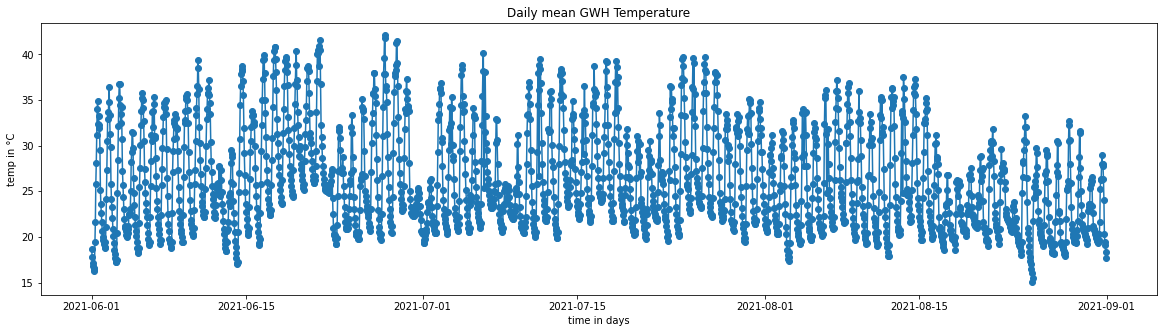

In [6]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.plot(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",                                                                                                                             
       title="Daily mean GWH Temperature")

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Daily mean GWH Temperature')]

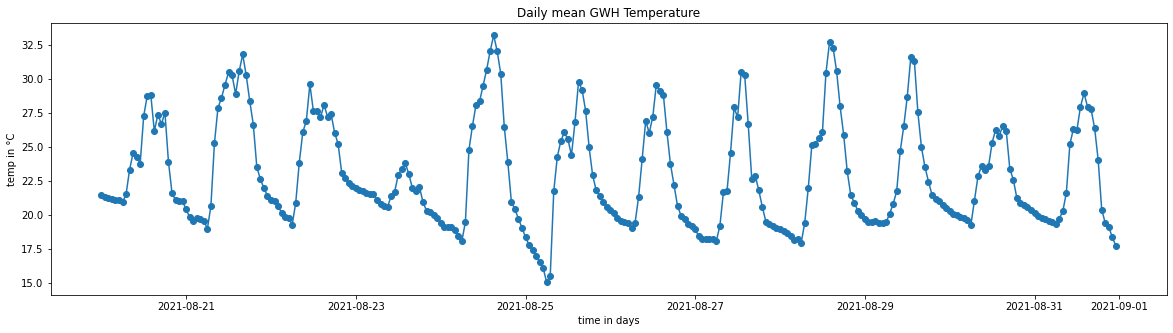

In [7]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_temp1_hourly_modelling_data.index, df_temp1_hourly_modelling_data['value'])
ax.plot(df_temp1_hourly_modelling_data.index, df_temp1_hourly_modelling_data['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",                                                                                                                             
       title="Daily mean GWH Temperature")

In [8]:
series = df_temp1_hourly['value'].values
result = adfuller(series)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -4.060323998666195
p-value: 0.0011255751387953688
Critial Values:
   1%, -3.4333532186762805
Critial Values:
   5%, -2.862866720471125
Critial Values:
   10%, -2.5674762791431696


Da (p-Wert) 0.0011 < (p-Wert Schwelle) 0.05 , wird die Nullhyppthese abgelehnt. Die Zeitreihe ist stationär. <br>

In [9]:
ndiffs(df_temp1_hourly)

NameError: name 'ndiffs' is not defined

## Stationarität herstellen

### Saisonalität entfernen

Die Zeitreihe ist nach dem ADF-Test zwar stationär, allerdings scheint noch eine Saisonalität vorzuliegen. Da angenommen wird, dass sich die Temperatur im Tagesrhythmus verändert, wird die Differenz von 24 gebildet. d.h. die Zeitreihe wird mit ihrer, um 24h verschobenen, Zeitreihe abgezogen. Um die Varianzen zu reduzieren wird das Ergbnis nochmal um 1 differenziert.

                        value
timestamp                    
2021-06-01 00:00:00       NaN
2021-06-01 01:00:00       NaN
2021-06-01 02:00:00       NaN
2021-06-01 03:00:00       NaN
2021-06-01 04:00:00       NaN
...                       ...
2021-08-31 19:00:00 -2.307852
2021-08-31 20:00:00 -0.630584
2021-08-31 21:00:00 -0.145508
2021-08-31 22:00:00 -0.593927
2021-08-31 23:00:00 -0.407428

[2208 rows x 1 columns]


[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Detrended GWH Temperature')]

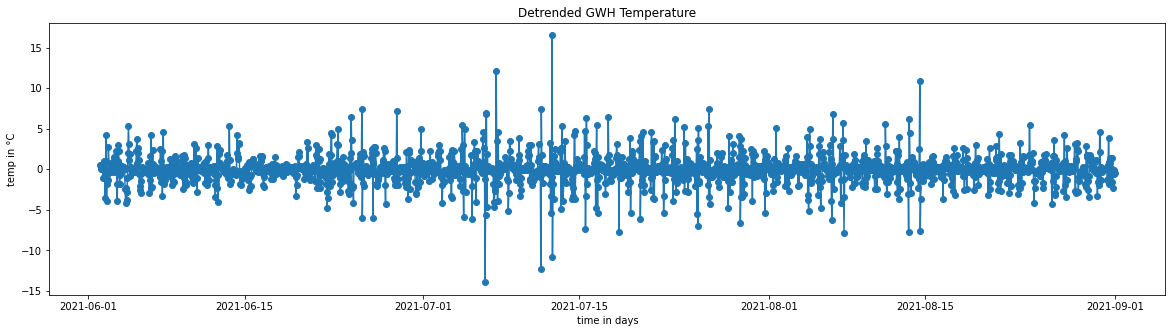

In [11]:
series_temp1_stationary_diff = df_temp1_hourly['value'].diff(periods=24)
series_temp1_stationary_diff = series_temp1_stationary_diff -series_temp1_stationary_diff.shift(1)
df_temp1_detrend = pd.DataFrame(series_temp1_stationary_diff)
df_temp1_detrend.columns.values[0] = "value"
print(df_temp1_detrend)

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_temp1_detrend.index, df_temp1_detrend['value'])
ax.scatter(df_temp1_detrend.index, df_temp1_detrend['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="Detrended GWH Temperature")

In [12]:
df_temp1_detrend.isnull().values.any()
df_temp1_detrend = df_temp1_detrend.fillna(method='bfill')

series = df_temp1_detrend
result = adfuller(series, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.867136955259868
p-value: 1.6847890618418885e-27
Critial Values:
   1%, -3.4333518400589074
Critial Values:
   5%, -2.8628661117509484
Critial Values:
   10%, -2.567475955039574


In [13]:
df_clean = df_temp1_detrend['value']

## Autocorrelation

### ACF und PACF mit stationären Daten

<b>ACF</b> 

Die ACF gibt an wie groß der Zusammenhang zwischen dem aktuellen Wert und vergangenen Werten ist. <br>
Aus dem ACF-Plot kann die Ordnung des MA-Modells geschätzt werden.

<b>ACF für tägliche Daten:</b>

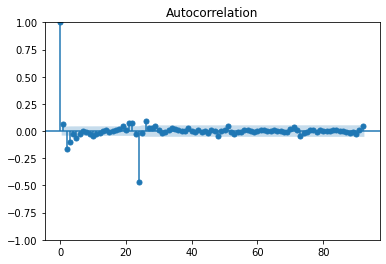

In [30]:
acf_result = stattools.acf(df_clean)
acf_plot_temp1_hourly = tsaplots.plot_acf(df_clean, lags=92)

Ab einem Lag von 3 befindet sich die ACF erstmals innerhalb des Signifikanzbandes, d.h. die MA-Ordnung q kann bis zu 3 betragen. 

<b>PACF</b> 

Die PACF gibt an wie groß der Zusammenhang zwischen Werten ist, die nicht durch die dazwischenliegenden Lags erklärt wird.<br>
Aus dem PACF-Plot kann die Ordnung des AR-Modells geschätzt werden

<b>PACF für tägliche Daten:</b>

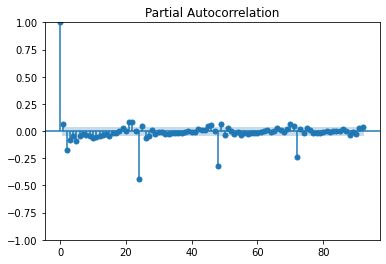

In [29]:
pacf_plot_temp1_hourly = tsaplots.plot_pacf(df_clean,  method='ywm', lags=92)

Ab einem Lag von 2 befindet sich die PACF erstmals innerhalb des Signifikanzbandes, d.h. die Ordnung p kann bis zu 5 betragen. 

In [16]:
# Frequenz der Zeitreihe wird festgelegt
df_temp1_hourly_modelling_data = df_temp1_hourly_modelling_data.asfreq(pd.infer_freq(df_temp1_hourly_modelling_data.index))

In [17]:
# Für die Evaluation: Training-Set, Testing-Set bilden
train_end = datetime.datetime(2021,8,26)
test_end = datetime.datetime(2021,8,31)

train_data = df_temp1_hourly_modelling_data.sort_index().loc['2021-08-20':'2021-08-26']
test_data = df_temp1_hourly_modelling_data[train_end + timedelta(days=1):test_end]

In [18]:
print(train_data)
print(test_data)

                         value
timestamp                     
2021-08-20 00:00:00  21.442055
2021-08-20 01:00:00  21.310824
2021-08-20 02:00:00  21.221267
2021-08-20 03:00:00  21.169295
2021-08-20 04:00:00  21.112223
...                        ...
2021-08-26 19:00:00  20.647810
2021-08-26 20:00:00  19.932687
2021-08-26 21:00:00  19.671237
2021-08-26 22:00:00  19.339797
2021-08-26 23:00:00  19.139845

[168 rows x 1 columns]
                         value
timestamp                     
2021-08-27 00:00:00  18.947255
2021-08-27 01:00:00  18.403073
2021-08-27 02:00:00  18.244310
2021-08-27 03:00:00  18.238506
2021-08-27 04:00:00  18.203772
...                        ...
2021-08-30 20:00:00  20.879443
2021-08-30 21:00:00  20.734370
2021-08-30 22:00:00  20.541763
2021-08-30 23:00:00  20.355409
2021-08-31 00:00:00  20.148985

[97 rows x 1 columns]


In [19]:
# Prediction Start und Ende festlegen
pred_start = test_data.index[0]
pred_end =test_data.index[-1]

# SARIMA

In [26]:
# SARIMA-Modell fitten
stepwise_fit = auto_arima(df_temp1_hourly_modelling_data, start_p = 0, start_q = 0,
                            test='adf',
                            max_p = 3, max_q = 3, 
                            m=24,
                            d=0,
                            seasonal=True,
                            start_P=0, start_Q=0,
                            max_P = 2, max_Q = 2, 
                            D=0,
                            error_action='ignore',  # ignoriert Ordnungen, die nicht funktionieren
                            suppress_warnings=True,  # ignoriert Konvergenzwarnungen
                            stepwise=True)

stepwise_fit.summary()

KeyboardInterrupt: 

model = SARIMAX(df_clean, order=(3,1,0), seasonal_order=(0,0,1,24))

In [ ]:
model = SARIMAX(train_data, order=(0,0,0), seasonal_order=(1,0,[1],24))
model_fit = model.fit()
predictions = model_fit.predict(start=pred_start, end=pred_end)

In [ ]:
# resid = test_data - predictions
# plt.plot(resid)
# acf_result = stattools.acf(resid)
# acf_plot_temp1_hourly = tsaplots.plot_acf(resid, lags=45)
# pacf_plot_temp1_hourly = tsaplots.plot_pacf(resid,  method='ywm')

In [ ]:
model = SARIMAX(train_data, order=(1,0,0), seasonal_order=(0,1,0,24))
model_fit = model.fit()
predictions = model_fit.predict(start=pred_start, end=pred_end)

plt.figure(figsize=(20,10))
plt.plot(train_data)
plt.plot(model_fit.fittedvalues, color='red')
plt.plot(test_data, label='Trend of time series',color='#003049')
plt.plot(predictions, label='Trend of time series',color='#f77f00')

## Gridsearch

In [31]:
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q)) # alle Kombis von p,d,q
p2 = d2 = q2 = range(0, 2)
pdq2 = list(itertools.product(p2,d2,q2))
s = 24 # Zykluslänge
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2] # alle Kombis von p,d,q
combs = {}
aics = []

In [32]:
for combination in pdq:
    for seasonal_combination in pdqs2:
        
        model = SARIMAX(train_data, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
        model = model.fit(disp=False)
        combs.update({model.aic : [combination, seasonal_combination]})
        aics.append(model.aic)

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as star

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters

In [35]:
best_aic = min(aics)
print('best aic: ', round(best_aic, 3))
print(40*'==')
print ('ARIMA parameters: (', combs[best_aic][0][0], ',', combs[best_aic][0][1],',', combs[best_aic][0][2],')')
print('Seasonal parameters:', combs[best_aic][1])



best aic:  458.278
ARIMA parameters: ( 2 , 0 , 2 )
Seasonal parameters: (0, 1, 1, 24)
[1540.2011011213924, 1392.0098082480085, 757.6799416992387, 686.6755912564238, 978.2069652269147, 910.5167186681865, 726.178269711404, 687.849782532496, 1319.9903731513575, 1176.157881657683, 633.6657513093503, 572.5081659976111, 827.1422613174337, 770.4819928642953, 609.3773934412408, 574.3097385419646, 1126.4647248909619, 993.2942564815821, 548.5526427720179, 497.8239179796176, 715.2408783883686, 669.5449349764426, 527.9267225259589, 499.71479203741353, 605.004063208147, 559.2924011720031, 507.8081238209266, 468.9943550037577, 557.2739427747022, 544.010321852534, 497.49791262017845, 470.8086736744217, 570.4909205981178, 539.3539492162627, 503.3678997313764, 467.17239562265365, 542.7441481562971, 535.5199855334118, 494.034436322724, 468.869662793649, 559.9838129517121, 535.9212301199916, 505.14340551634825, 469.14026027901207, 540.5611348554669, 535.0852445282555, 495.7818383959724, 470.8404795501045

## Ausprobieren

In [69]:
model = SARIMAX(train_data, order=(2,0,2), seasonal_order=(0,1,1,24))
model_fit = model.fit()
predictions = model_fit.predict(start=pred_start, end=pred_end)

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [70]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  168
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 24)   Log Likelihood                -223.139
Date:                              Fri, 17 Jun 2022   AIC                            458.278
Time:                                      18:00:46   BIC                            476.096
Sample:                                  08-20-2021   HQIC                           465.518
                                       - 08-26-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0312      0.161      0.193      0.847      -0.285       0.348
ar.L2          0.6194      0.160      3.875      0.000       0.306       0.933
ma.L1          1.1184      0.174      6.418      0.000       0.777       1.460
ma.L2          0.4004      0.089      4.484      0.000       0.225       0.575
ma.S.L24      -0.7822      0.116     -6.741      0.000      -1.010      -0.555
sigma2         1.1005      0.134      8.200      0.000       0.837       1.364
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                18.13
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.07
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

1.2833230073227149


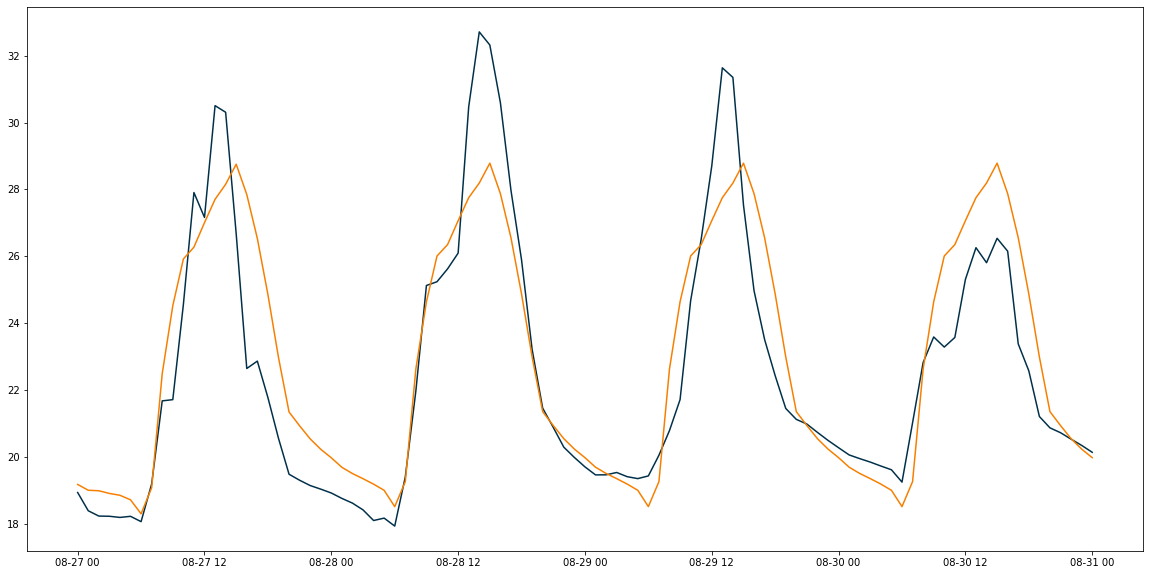

In [72]:
plt.figure(figsize=(20,10))
plt.plot(test_data, label='Trend of time series',color='#003049')
plt.plot(predictions, label='Trend of time series',color='#f77f00')
print(mean_absolute_error(test_data, predictions))

In [60]:
model1 = SARIMAX(train_data, order=(1,0,0), seasonal_order=(0,1,1,24))
model_fit1 = model1.fit()
predictions1 = model_fit1.predict(start=pred_start, end=pred_end)

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [67]:
model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  168
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 24)   Log Likelihood                -230.319
Date:                              Fri, 17 Jun 2022   AIC                            466.638
Time:                                      17:51:57   BIC                            475.547
Sample:                                  08-20-2021   HQIC                           470.258
                                       - 08-26-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8864      0.037     23.726      0.000       0.813       0.960
ma.S.L24      -0.8136      0.136     -5.976      0.000      -1.080      -0.547
sigma2         1.1969      0.157      7.645      0.000       0.890       1.504
===================================================================================
Ljung-Box (L1) (Q):                   5.87   Jarque-Bera (JB):                11.86
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.14
Prob(H) (two-sided):                  0.85   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

1.2630146563191096


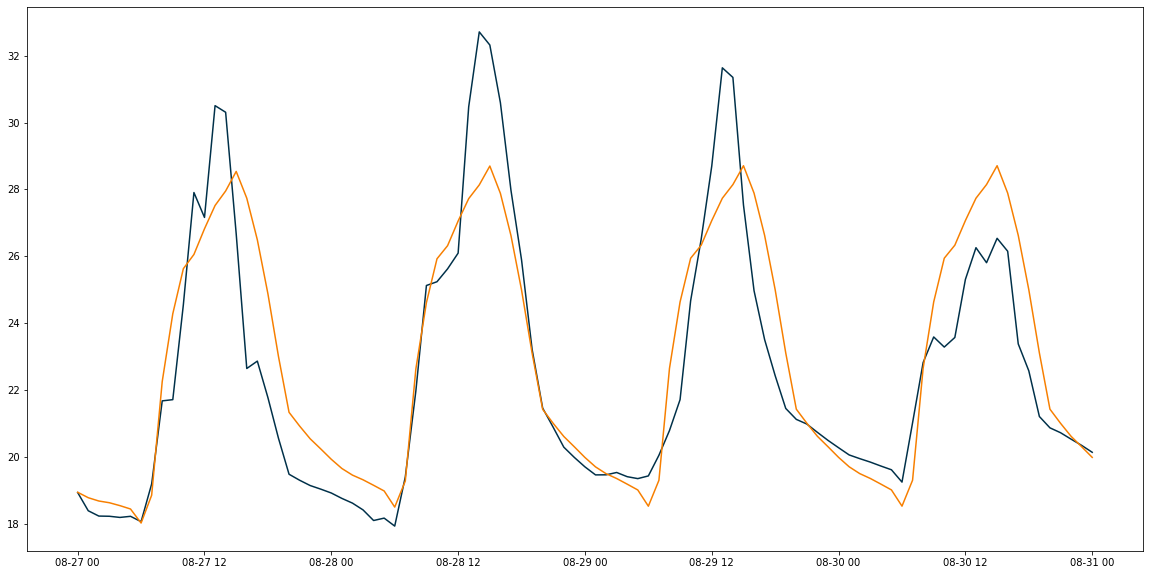

In [68]:
plt.figure(figsize=(20,10))
plt.plot(test_data, label='Trend of time series',color='#003049')
plt.plot(predictions1, label='Trend of time series',color='#f77f00')
print(mean_absolute_error(test_data, predictions1))

## Fehlermaße

In [ ]:
print(mean_absolute_error(test_data, predictions))

